In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
import rebound
from imageio.v2 import imread

plt.style.use('paper.mplstyle')
%matplotlib inline

Need githash 6fb912f615ca542b670ab591375191d1ed914672 to load this simarchive (which causes other library clashes). So load parameters by hand

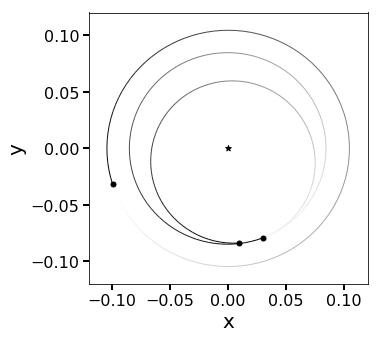

In [12]:
sa = rebound.SimulationArchive('sa0000000.bin')
sim = sa[0]
fig = rebound.OrbitPlot(sim)

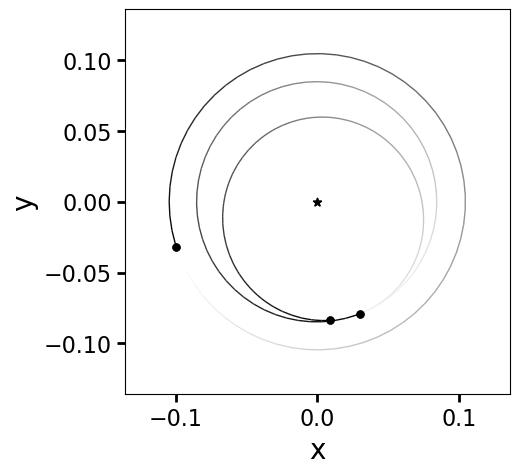

In [2]:
sim0 = rebound.Simulation()
sim0.add(m=1.071, x=4.27132711988e-07, y=5.09378504589e-07, z=-3.31732947001e-11, vx=-1.87347624727e-05, vy=1.29184196884e-05, vz=-1.78479124901e-08)
sim0.add(m=3.40200158313e-06, x=0.00912658723541, y=-0.0837335636642, z=-3.93237358501e-05, vx=3.24015608012, vy=0.201926023053, vz=0.00282454936881)
sim0.add(m=1.18120724745e-06, x=0.0299543029823, y=-0.079142028567, z=3.84385789343e-05, vx=3.32328889954, vy=1.27774236571, vz=-0.00303746225109)
sim0.add(m=5.25899405109e-06, x=-0.0996179180747, y=-0.0317930621184, z=2.35604149801e-05, vx=0.9728897791, vy=-3.04846488194, vz=0.00248980416222)
sim0.move_to_com()
sim0.dt = 0.004057
sim0.integrator="whfast"
fig = rebound.OrbitPlot(sim0)

In [87]:
def makesystem(seed, emax):
    random.seed(seed)
    ps = sim0.particles
    sim = rebound.Simulation()
    sim.add(m=ps[0].m)
    for i in [1,2,3]:
        sim.add(m=ps[i].m, a=ps[i].a, e=random.random()*emax, pomega=random.random()*2*np.pi, inc=random.random()*np.pi/180, Omega=random.random()*2*np.pi)
    return sim
    
def predict_stable(seed, emax=0.2):
    sim = makesystem(seed, emax)
    return (seed, model.predict_stable(sim))

def predict_stableA(seed, emax=0.2):
    sim = makesystem(seed, emax)
    return (seed, analyticalmodel.predict_stable(sim))

def randomplot(fig, ax, seed, emax, alpha=0.1, linewidth=1):
    sim = makesystem(seed, emax=emax)
    colors = ['dodgerblue','yellow','crimson']
    for p,c in zip(sim.particles[1:], colors):
        o = np.array(p.sample_orbit())
        ax.plot(o[:,0], o[:,1], linewidth=linewidth, color=c, zorder=0, alpha=alpha)
        ax.plot([o[:,0][-1], o[:,0][0]], [o[:,1][-1], o[:,1][0]], linewidth=linewidth, color=c, zorder=0, alpha=alpha)
    return fig, ax

In [4]:
%%time
from spock import FeatureClassifier
model = FeatureClassifier()


[23:41:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:888: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
CPU times: user 1.61 s, sys: 627 ms, total: 2.24 s
Wall time: 20.1 s


In [16]:
18*60/3000

0.36

In [63]:
%%time

try:
    stableseeds = np.loadtxt('prseeds4.txt')
except: 
    Nsamp=30000
    res = np.zeros((Nsamp, 2))
    for seed in range(Nsamp):
        res[seed] = predict_stable(seed, emax=0.2)
    
    #mask = res[:,1] > 0.01 # discard smallest probabilities to limit # plotted orbits
    #stableseeds = res[mask]
    np.savetxt('prseeds4.txt', res)

CPU times: user 2h 10min 28s, sys: 1h 4min 7s, total: 3h 14min 36s
Wall time: 55min 30s


In [20]:
from spock import AnalyticalClassifier
analyticalmodel = AnalyticalClassifier()

In [64]:
%%time

try:
    stableseedsA = np.loadtxt('prseeds4A.txt')
except: 
    Nsamp=30000
    res = np.zeros((Nsamp, 2))
    for seed in range(Nsamp):
        res[seed] = predict_stableA(seed, emax=0.2)
    
    #mask = res[:,1] > 0.01 # discard smallest probabilities to limit # plotted orbits
    #stableseedsA = res[mask]
    np.savetxt('prseeds4A.txt', res)

CPU times: user 27min 3s, sys: 6.46 s, total: 27min 10s
Wall time: 27min 10s


# 2D array of (seed, stability prob)

In [12]:
stableseeds.shape

(314, 2)

In [5]:
stableseeds.shape

(3215, 2)

In [65]:
stableseeds = np.loadtxt('prseeds4.txt')
eff_samples = stableseeds[:,1].sum() # add up all probabilities to plot same # of effective samples for equal alpha in both and fair comparison
eff_samples

972.8257428249344

In [66]:
stableseedsA = np.loadtxt('prseeds4A.txt')
eff_samples = stableseedsA[:,1].sum() # add up all probabilities to plot same # of effective samples for equal alpha in both and fair comparison
eff_samples

929.7087070575012

In [37]:
eff_samples = stableseeds[:,1].sum() # add up all probabilities to plot same # of effective samples for equal alpha in both and fair comparison
eff_samples

963.448148121126

In [59]:
stableseeds[:,1][249]

0.01133786141872406

In [60]:
stableseedsA[:,1][249]

0.0

In [49]:
sim = makesystem(249, emax=0.2)
analyticalmodel.predict_stable(sim)

0.0

In [50]:
sim = makesystem(249, emax=0.2)
model.predict_stable(sim)

0.011337861

In [34]:
idx

array([112, 206, 201,  19,  74, 193,  87, 169, 164,  20,  81, 138, 310,
       258, 291, 110, 229,  49, 236, 246,  63, 176, 165,  85,  51, 155,
       212, 113, 261, 238, 257, 168, 122, 179, 180,  48,  45, 297,  35,
       224, 262,  13, 217, 124, 251,  77, 215, 188, 189,  62,  60, 218,
       134, 225, 253,   2, 260, 247, 187, 127,  89, 312, 235,   6, 293,
       304,  57,  80, 119, 228, 295, 125, 294, 239,   9, 231, 276, 278,
       202, 116, 288, 233,  10, 204, 174,  12,  14,  78, 213, 250,  39,
       182, 283, 269, 156,  24,  30,  91, 267, 242, 140,  15,  88, 136,
        83, 264, 146, 144,  69,  76,   8, 199,  50, 163,  79, 266,  70,
        99,  21, 207,  29, 141,   5,  31,  37, 301, 145, 311, 292, 158,
       109, 111, 120, 307,  98,  59, 160, 148, 121, 265,  40, 166, 133,
       117, 289,  46, 286, 178,  11, 223, 123, 118, 181,   1, 102,  58,
       157, 106, 252, 104, 220,  65,  18,  17, 197, 259, 126, 290,  72,
       237,  53, 313, 192,  66,  97, 287, 190, 170, 263, 103,  3

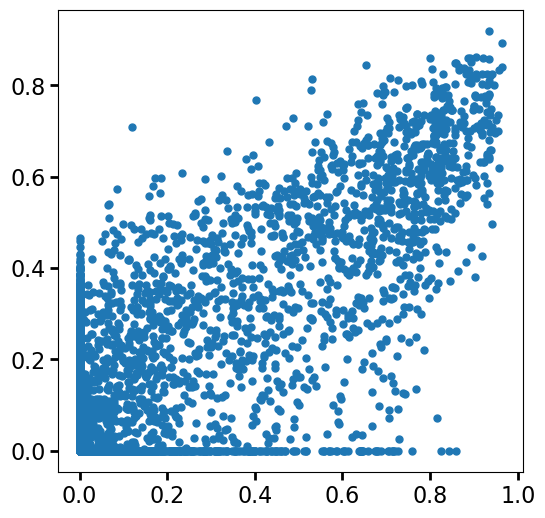

In [67]:
idx = np.argsort(stableseeds[:,1])
fig, ax = plt.subplots()
ax.plot(stableseeds[:,1][idx], stableseedsA[:,1][idx], '.')

CPU times: user 8 s, sys: 103 ms, total: 8.1 s
Wall time: 8.11 s


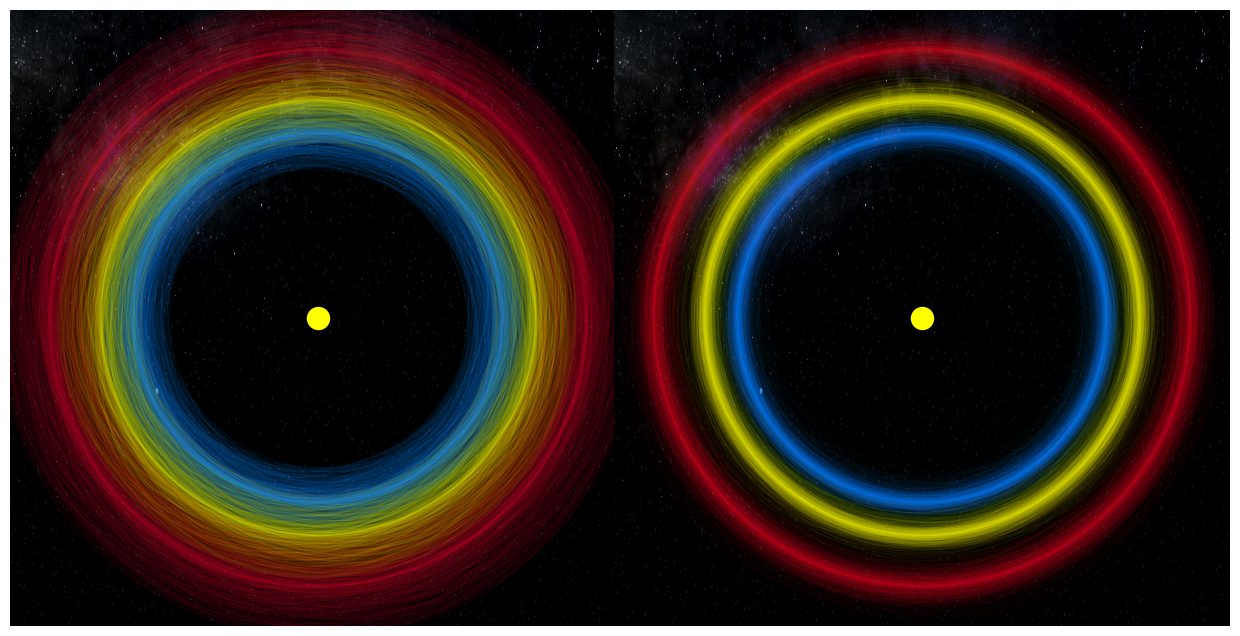

In [73]:
%%time

mask = stableseeds[:,1] > 0.01 # discard smallest probabilities to limit # plotted orbits
stableseeds = stableseeds[mask]

mask = stableseedsA[:,1] > 0.01 # discard smallest probabilities to limit # plotted orbits
stableseedsA = stableseedsA[mask]

eff_samples = stableseeds[:,1].sum() # add up all probabilities to plot same # of effective samples for equal alpha in both and fair comparison

fig, axarr = plt.subplots(ncols=2, figsize=(16,8))
plt.subplots_adjust(wspace=-0.05)
lim=0.12

for i in range(int(eff_samples)):
    fig, axarr[0] = randomplot(fig, axarr[0], i, emax=0.2, alpha=0.03)

for seed, prob in stableseeds:
    fig, axarr[1] = randomplot(fig, axarr[1], int(seed), emax=0.2, alpha=0.03*prob)

#for seed, prob in stableseedsA:
#    fig, axarr[1] = randomplot(fig, axarr[1], int(seed), emax=0.2, alpha=0.02*prob)

for ax in axarr:
    ax.set_rasterization_zorder(1)
    ax.scatter([0],[0], s=250, color='yellow')
    ax.set_xlim([-lim, lim])
    ax.set_ylim([-lim, lim])
    ax.axis('off')
    
    bkg = imread('US_background_image.png')
    ax.imshow(bkg, extent=[-lim, lim, -lim, lim], zorder=-1)
    
#fig.text(0.42, 0.76, 'Kepler-431', color='w', fontsize=36)
#fig.text(0.45, 0.68, 'System', color='w', fontsize=36)

#fig.text(0.19, 0.28, 'Orbits consistent with', color='w', fontsize=28)
#fig.text(0.15, 0.2, 'observations (superimposed)', color='w', fontsize=28)

#fig.text(0.55, 0.28, 'With stability constraints', color='w', fontsize=28)


#fig.savefig('spockpr.jpg')

CPU times: user 23.8 s, sys: 1.67 s, total: 25.5 s
Wall time: 26.1 s


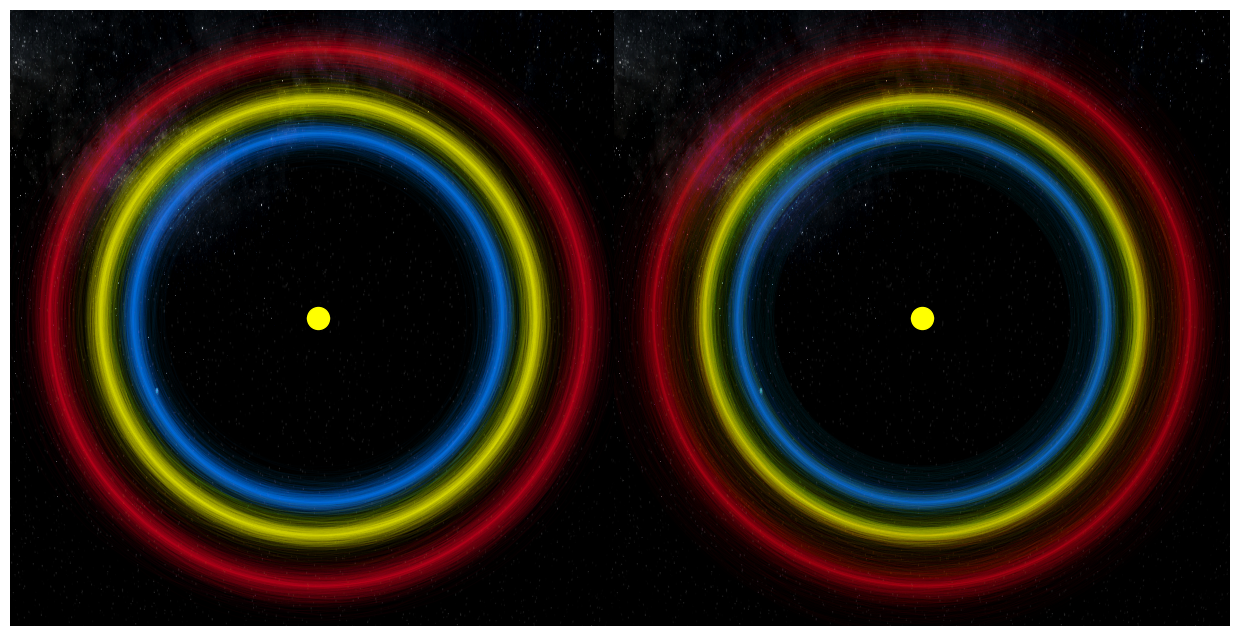

In [90]:
%%time

mask = stableseeds[:,1] > 0.01 # discard smallest probabilities to limit # plotted orbits
stableseeds = stableseeds[mask]

mask = stableseedsA[:,1] > 0.01 # discard smallest probabilities to limit # plotted orbits
stableseedsA = stableseedsA[mask]

eff_samples = stableseeds[:,1].sum() # add up all probabilities to plot same # of effective samples for equal alpha in both and fair comparison

fig, axarr = plt.subplots(ncols=2, figsize=(16,8))
plt.subplots_adjust(wspace=-0.05)
lim=0.12

#for i in range(int(eff_samples)):
#    fig, axarr[0] = randomplot(fig, axarr[0], i, emax=0.2, alpha=0.03)

for seed, prob in stableseeds:
    fig, axarr[0] = randomplot(fig, axarr[0], int(seed), emax=0.2, alpha=0.03*prob)

for seed, prob in stableseedsA:
    fig, axarr[1] = randomplot(fig, axarr[1], int(seed), emax=0.2, alpha=0.03*prob)

for ax in axarr:
    ax.set_rasterization_zorder(1)
    ax.scatter([0],[0], s=250, color='yellow')
    ax.set_xlim([-lim, lim])
    ax.set_ylim([-lim, lim])
    ax.axis('off')
    
    bkg = imread('US_background_image.png')
    ax.imshow(bkg, extent=[-lim, lim, -lim, lim], zorder=-1)
    
#fig.text(0.42, 0.76, 'Kepler-431', color='w', fontsize=36)
#fig.text(0.45, 0.68, 'System', color='w', fontsize=36)

#fig.text(0.19, 0.28, 'Orbits consistent with', color='w', fontsize=28)
#fig.text(0.15, 0.2, 'observations (superimposed)', color='w', fontsize=28)

#fig.text(0.55, 0.28, 'With stability constraints', color='w', fontsize=28)


#fig.savefig('spockpr.jpg')

In [74]:
%%time

stableseeds = np.loadtxt('prseeds4.txt')
idx = np.argsort(stableseeds[:,1])

CPU times: user 8.8 ms, sys: 5.12 ms, total: 13.9 ms
Wall time: 15.1 ms


In [76]:
stableseeds[:,1][idx[-1]]

0.9648181796073914

In [77]:
idx[-1]

2430

CPU times: user 94.4 ms, sys: 13 ms, total: 107 ms
Wall time: 110 ms


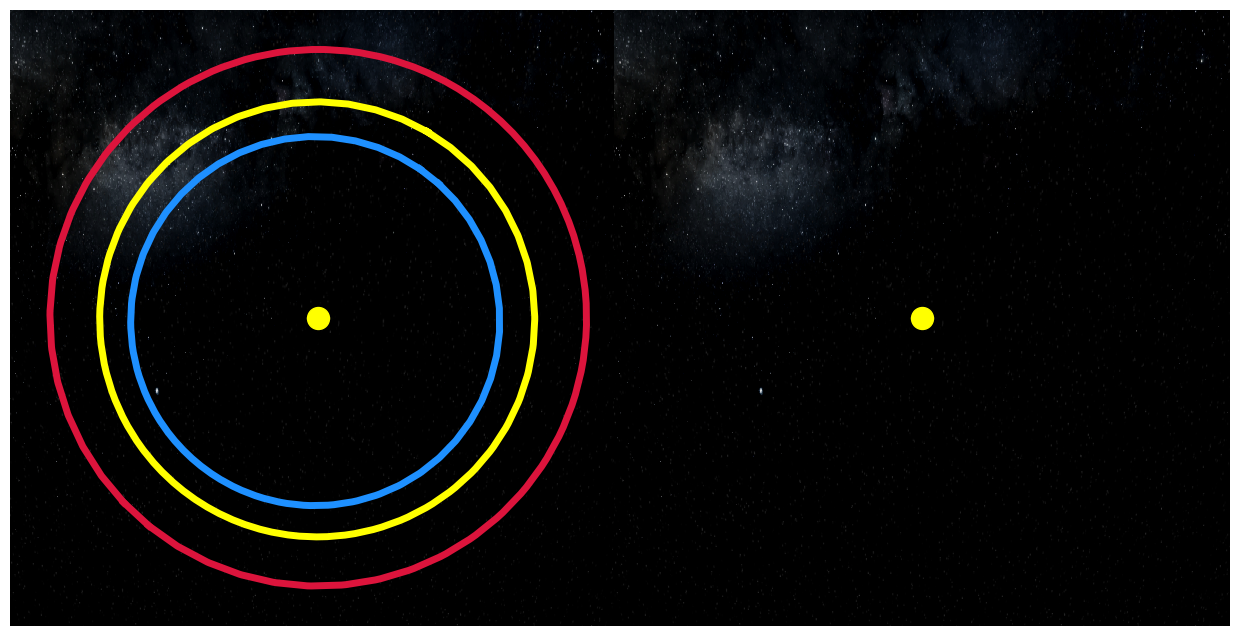

In [88]:
%%time

stableseeds = np.loadtxt('prseeds4.txt')
idx = np.argsort(stableseeds[:,1])
moststable = idx[-1]

fig, axarr = plt.subplots(ncols=2, figsize=(16,8))
plt.subplots_adjust(wspace=-0.05)
lim=0.12

fig, axarr[0] = randomplot(fig, axarr[0], 2430, emax=0.2, alpha=1, linewidth=5)

#for seed, prob in stableseeds:
#    fig, axarr[1] = randomplot(fig, axarr[1], int(seed), emax=0.2, alpha=0.03*prob)

#for seed, prob in stableseedsA:
#    fig, axarr[1] = randomplot(fig, axarr[1], int(seed), emax=0.2, alpha=0.02*prob)

for ax in axarr:
    ax.set_rasterization_zorder(1)
    ax.scatter([0],[0], s=250, color='yellow')
    ax.set_xlim([-lim, lim])
    ax.set_ylim([-lim, lim])
    ax.axis('off')
    
    bkg = imread('US_background_image.png')
    ax.imshow(bkg, extent=[-lim, lim, -lim, lim], zorder=-1)
    
#fig.text(0.42, 0.76, 'Kepler-431', color='w', fontsize=36)
#fig.text(0.45, 0.68, 'System', color='w', fontsize=36)

#fig.text(0.19, 0.28, 'Orbits consistent with', color='w', fontsize=28)
#fig.text(0.15, 0.2, 'observations (superimposed)', color='w', fontsize=28)

#fig.text(0.55, 0.28, 'With stability constraints', color='w', fontsize=28)


#fig.savefig('spockpr.jpg')